# Benchmarking [Perspective API](https://developers.perspectiveapi.com/s/about-the-api?language=en_US)

## Libraries

In [1]:
import requests
from pathlib import Path
from time import sleep
import os
import pandas as pd
import json
from tqdm.rich import tqdm
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.text import Text
import matplotlib.pyplot as plt
import warnings

tqdm.pandas(desc="Fetching moderation scores")
console = Console()
warnings.filterwarnings("ignore")

## Global variables

In [7]:
ROOT = Path("../..")
DATA_DIR = ROOT / "data"
BENCHMARK_PATH = DATA_DIR / "benchmark_jigsaw" / "benchmark_jigsaw.csv"
output_path = DATA_DIR / "benchmark_jigsaw" / "eng-perspective_scores.csv"
API_KEY_PATH = DATA_DIR / "confidential" / "perspective_API.txt"
API_KEY = API_KEY_PATH.read_text().strip()
console = Console()

In [8]:
os.environ["HTTP_PROXY"] = "socks5h://127.0.0.1:1080"
os.environ["HTTPS_PROXY"] = "socks5h://127.0.0.1:1080"

## Load dataset

In [9]:
df = pd.read_csv(BENCHMARK_PATH, encoding="utf-8")
df = df.dropna(subset=["content", "label"])
df["label"] = df["label"].astype(int)

label_counts = df["label"].value_counts().reset_index()
label_counts.columns = ["label", "count"]
table = Table(title="Label Counts", show_lines=True)
table.add_column("Label", justify="center", style="cyan")
table.add_column("Count", justify="center", style="yellow")
table.add_row("Total Rows", str(len(df)))
for _, row in label_counts.iterrows():
    table.add_row(str(row["label"]), str(row["count"]))
console.print(table, justify="left")
df.sample(5, random_state=42)

     Label Counts                                                                                                  
┏━━━━━━━━━━━━┳━━━━━━━┓                                                                                             
┃   Label    ┃ Count ┃                                                                                             
┡━━━━━━━━━━━━╇━━━━━━━┩                                                                                             
│ Total Rows │  396  │                                                                                             
├────────────┼───────┤                                                                                             
│     0      │  198  │                                                                                             
├────────────┼───────┤                                                                                             
│     1      │  198  │                                                                                             
└────────────┴───────┘

,msg_id,original_text,content,label
78,ddb11abeca87bb3c,birth place \n\n YC was not born in Jonesboro...,lieu de naissance \n\nYC n'est pas né à Jones...,0
277,6e9826f166b7d7fe,Nazis like you deserve worse than death. \n\nI...,Des nazis comme toi méritent pire que la mort....,1
250,5bff63ef016af9be,You can rationalize your dishonesty however yo...,Tu peux rationaliser ton malhonnêteté comme tu...,1
55,e8ea81d9eac81735,Deletion\nThis has been tagged for Speedy Dele...,Suppression \nCeci a été marqué pour une supp...,0
391,bf5aae5b17fb0b77,because I am a huge faggot,parce que je suis un énorme pédé,1


## Define prediction function

In [10]:
def predict(text):
    url = f"https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze?key={API_KEY}"

    data = {
        "comment": {"text": text},
        "languages": ["fr"],
        "requestedAttributes": {
            "TOXICITY": {},
            "INSULT": {},
            "THREAT": {},
            "PROFANITY": {},
            "SEVERE_TOXICITY": {},
            # Optional: "IDENTITY_ATTACK": {}, "FLIRTATION": {}, etc.
        }
    }

    response = requests.post(url, json=data)
    if response.status_code != 200:
        raise Exception(f"Perspective API error {response.status_code}: {response.text}")
    
    result = response.json()
    scores = {
        attr: result["attributeScores"][attr]["summaryScore"]["value"]
        for attr in result["attributeScores"]
    }
    sleep(0.5)
    return scores

## Run prediction

In [11]:
df["toxicity_score"] = df["original_text"].progress_apply(predict)
df = df.dropna(subset=["toxicity_score"])

Output()

In [12]:
def is_toxic(score, threshold=0.5):
    return any(
        score[attr] >= threshold for attr in ["TOXICITY", "INSULT", "THREAT", "PROFANITY", "SEVERE_TOXICITY"]
    )


In [13]:
df["is_toxic"] = df["toxicity_score"].apply(is_toxic)

In [14]:
for i, row in df.sample(5, random_state=42).iterrows():
    content = Text(row['content'], style="bold")
    toxicity = f"[yellow]Toxicity Score:[/yellow] [bold]{row['is_toxic']}[/bold]"
    label = f"[cyan]Label:[/cyan] [bold]{row['label']}[/bold]"
    panel = Panel.fit(
        f"{content}\n\n{toxicity}\n{label}",
        title=f"Exemple {i+1}",
        border_style="magenta"
    )
    console.print(panel)

╭─────────────── Exemple 79 ───────────────╮
│ lieu de naissance                        │
│                                          │
│ YC n'est pas né à Jonesboro, en Géorgie. │
│                                          │
│ Toxicity Score: False                    │
│ Label: 0                                 │
╰──────────────────────────────────────────╯

╭────────────────── Exemple 278 ──────────────────╮
│ Des nazis comme toi méritent pire que la mort.  │
│                                                 │
│ Je vais m'assurer que tu souffres horriblement. │
│                                                 │
│ Toxicity Score: True                            │
│ Label: 1                                        │
╰─────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Exemple 251 ──────────────────────────────────────────────────╮
│ Tu peux rationaliser ton malhonnêteté comme tu veux, mais même Wikipédia a un article sur la mosquée de Ground  │
│ Zero, espèce de connard.                                                                                        │
│                                                                                                                 │
│ Toxicity Score: True                                                                                            │
│ Label: 1                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── Exemple 56 ─────────────────────────────────────────────╮
│ Suppression                                                                                         │
│ Ceci a été marqué pour une suppression rapide car c'est le même article précédemment supprimé sous. │
│                                                                                                     │
│ Toxicity Score: False                                                                               │
│ Label: 0                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────── Exemple 392 ───────────╮
│ parce que je suis un énorme pédé │
│                                  │
│ Toxicity Score: True             │
│ Label: 1                         │
╰──────────────────────────────────╯

## Metrics & Report        

| Metric                     | Formula                                           | Interpretation                                                                                                       |
| -------------------------- | ------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Precision**              | `TP / (TP + FP)`                                  | Of the samples predicted **toxic**, how many were **actually toxic**? <br>→ High precision = **low false positives** |
| **Recall** *(Sensitivity)* | `TP / (TP + FN)`                                  | Of the **actual toxic** samples, how many did we **correctly identify**? <br>→ High recall = **low false negatives** |
| **F1-score**               | `2 * (Precision * Recall) / (Precision + Recall)` | Harmonic mean of precision and recall. <br>→ Best when **balance** is needed                                         |
| **Accuracy**               | `(TP + TN) / (TP + TN + FP + FN)`                 | Fraction of all correct predictions (toxic and non-toxic). <br>→ Can be misleading on imbalanced data                |
| **ROC AUC**                | Area under the ROC Curve                          | Measures the **ranking ability** of the classifier. <br>→ Higher = better separation of toxic vs. non-toxic          |


In [15]:
y_true = df["label"]

In [16]:
# df = pd.read_csv(output_path, encoding="utf-8")
# df['toxicity_score'] = df['toxicity_score'].apply(lambda x: str(x).replace("'", '"'))
# df['toxicity_score'] = df['toxicity_score'].apply(lambda x: json.loads(x))
df

,msg_id,original_text,content,label,toxicity_score,is_toxic
0,e6865c831da40459,Combining 'Official requests for clemency' sec...,Combiner la section 'Demandes officielles de c...,0,"{'PROFANITY': 0.010245483, 'INSULT': 0.0076838...",False
1,cff2b456e5059b47,Web \n\nIs this her own website? 113.22.84.65,Web\n\nEst-ce son propre site web ? 113.22.84.65,0,"{'THREAT': 0.008919456, 'SEVERE_TOXICITY': 0.0...",False
2,880d3d608f37bee3,"RFCU \n\nFYI, I have opened Wikipedia:Requests...","RFCU \n\nPour info, j'ai ouvert Wikipedia:Requ...",0,"{'TOXICITY': 0.013445686, 'SEVERE_TOXICITY': 0...",False
3,dd29d52a4320a2e4,Monitor for cleanup: \nAs of the date signed b...,Surveillance pour nettoyage : \nÀ la date sig...,0,"{'SEVERE_TOXICITY': 0.0014781952, 'TOXICITY': ...",False
4,d70e773c975839e1,I concur and have done so.,Je suis d'accord et je l'ai fait.,0,"{'THREAT': 0.0072882893, 'TOXICITY': 0.0101156...",False
...,...,...,...,...,...,...
391,bf5aae5b17fb0b77,because I am a huge faggot,parce que je suis un énorme pédé,1,"{'THREAT': 0.012647836, 'TOXICITY': 0.76523775...",True
392,8947f2c12aea0a32,"If no-one beats me to it, I'll knock something...","Si personne ne me devance, je vais bricoler qu...",1,"{'THREAT': 0.42643023, 'PROFANITY': 0.09163318...",False
393,ccf05c5d4b791836,"ur a faggot, fuck off and get a real job and s...","T'es un pédé, casse-toi et trouve un vrai boul...",1,"{'SEVERE_TOXICITY': 0.65725857, 'TOXICITY': 0....",True
394,ae7a53526025c0e2,"I SAID SHUT UP, YOU STUPID, STUPID...","J'AI DIT FERME TA GUEULE, ESPÈCE DE BÊTE, BÊTE...",1,"{'SEVERE_TOXICITY': 0.34954423, 'THREAT': 0.02...",True


### Tuning the threshold

Best threshold: 0.4


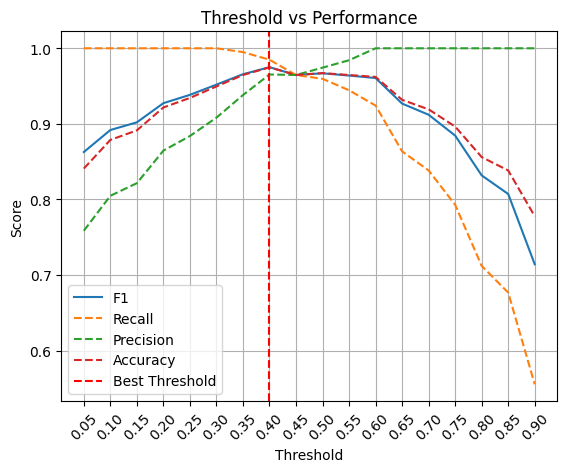

In [17]:
thresholds = [i / 100 for i in range(5, 95, 5)]  
results = []

for t in thresholds:
    preds = (df["toxicity_score"].apply(lambda x: is_toxic(x, threshold=t))).astype(int)
    precision = precision_score(df["label"], preds)
    recall = recall_score(df["label"], preds)
    f1 = f1_score(df["label"], preds)
    acc = accuracy_score(df["label"], preds)
    results.append((t, precision, recall, f1, acc))

best_threshold = max(results, key=lambda x: x[3])  # F1 score
print(f"Best threshold: {best_threshold[0]}")

# Convert to DataFrame for better display
threshold_df = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1", "Accuracy"])

plt.plot(threshold_df["Threshold"], threshold_df["F1"], label="F1")
plt.plot(threshold_df["Threshold"], threshold_df["Recall"], label="Recall", linestyle='--')
plt.plot(threshold_df["Threshold"], threshold_df["Precision"], label="Precision", linestyle='--')
plt.plot(threshold_df["Threshold"], threshold_df["Accuracy"], label="Accuracy", linestyle='--')
plt.axvline(x=best_threshold[0], color='r', linestyle='--', label='Best Threshold')
plt.xticks(threshold_df["Threshold"], rotation=45)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Performance")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
y_pred = (df["toxicity_score"].apply(lambda x: is_toxic(x, threshold=best_threshold[0]))).astype(float)

# Rapport de classification
report = classification_report(y_true, y_pred, digits=3, output_dict=True)
table = Table(title="Classification Report", show_lines=True)
table.add_column("Classe", style="cyan", justify="center")
table.add_column("Precision", justify="center")
table.add_column("Recall", justify="center")
table.add_column("F1-score", justify="center")
table.add_column("Support", justify="center")

for label, metrics in report.items():
    if label in ["accuracy", "macro avg", "weighted avg"]:
        continue
    table.add_row(
        str(label),
        f"{metrics['precision']:.3f}",
        f"{metrics['recall']:.3f}",
        f"{metrics['f1-score']:.3f}",
        f"{int(metrics['support'])}"
    )
# Ajout de l'accuracy
table.add_row(
    "[bold yellow]Accuracy[/bold yellow]",
    "-",
    "-",
    f"{report['accuracy']:.3f}",
    "-"
)
console.print(table)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
cm_table = Table(title="Matrice de Confusion", show_lines=True)
cm_table.add_column(" ", style="bold")
cm_table.add_column("Prédit 0", justify="center")
cm_table.add_column("Prédit 1", justify="center")
cm_table.add_row("Réel 0", str(cm[0, 0]), str(cm[0, 1]))
cm_table.add_row("Réel 1", str(cm[1, 0]), str(cm[1, 1]))
console.print(cm_table)

# ROC AUC
try:
    auc = roc_auc_score(y_true, y_pred)
    console.print(Panel(f"[bold green]ROC AUC Score : {auc:.3f}[/bold green]", title="ROC AUC"))
except:
    console.print(Panel("[bold red]Impossible de calculer le ROC AUC.[/bold red]", title="ROC AUC"))

                Classification Report                 
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃  Classe  ┃ Precision ┃ Recall ┃ F1-score ┃ Support ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│    0     │   0.985   │ 0.965  │  0.974   │   198   │
├──────────┼───────────┼────────┼──────────┼─────────┤
│    1     │   0.965   │ 0.985  │  0.975   │   198   │
├──────────┼───────────┼────────┼──────────┼─────────┤
│ Accuracy │     -     │   -    │  0.975   │    -    │
└──────────┴───────────┴────────┴──────────┴─────────┘

      Matrice de Confusion      
┏━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃        ┃ Prédit 0 ┃ Prédit 1 ┃
┡━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ Réel 0 │   191    │    7     │
├────────┼──────────┼──────────┤
│ Réel 1 │    3     │   195    │
└────────┴──────────┴──────────┘

╭──────────────────────────────────────────────────── ROC AUC ────────────────────────────────────────────────────╮
│ ROC AUC Score : 0.975                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Save the predictions

In [21]:
df["prediction"] = df['is_toxic'].astype(int)

In [22]:
df

,msg_id,original_text,content,label,toxicity_score,is_toxic,predictions,prediction
0,e6865c831da40459,Combining 'Official requests for clemency' sec...,Combiner la section 'Demandes officielles de c...,0,"{'PROFANITY': 0.010245483, 'INSULT': 0.0076838...",False,0,0
1,cff2b456e5059b47,Web \n\nIs this her own website? 113.22.84.65,Web\n\nEst-ce son propre site web ? 113.22.84.65,0,"{'THREAT': 0.008919456, 'SEVERE_TOXICITY': 0.0...",False,0,0
2,880d3d608f37bee3,"RFCU \n\nFYI, I have opened Wikipedia:Requests...","RFCU \n\nPour info, j'ai ouvert Wikipedia:Requ...",0,"{'TOXICITY': 0.013445686, 'SEVERE_TOXICITY': 0...",False,0,0
3,dd29d52a4320a2e4,Monitor for cleanup: \nAs of the date signed b...,Surveillance pour nettoyage : \nÀ la date sig...,0,"{'SEVERE_TOXICITY': 0.0014781952, 'TOXICITY': ...",False,0,0
4,d70e773c975839e1,I concur and have done so.,Je suis d'accord et je l'ai fait.,0,"{'THREAT': 0.0072882893, 'TOXICITY': 0.0101156...",False,0,0
...,...,...,...,...,...,...,...,...
391,bf5aae5b17fb0b77,because I am a huge faggot,parce que je suis un énorme pédé,1,"{'THREAT': 0.012647836, 'TOXICITY': 0.76523775...",True,1,1
392,8947f2c12aea0a32,"If no-one beats me to it, I'll knock something...","Si personne ne me devance, je vais bricoler qu...",1,"{'THREAT': 0.42643023, 'PROFANITY': 0.09163318...",False,0,0
393,ccf05c5d4b791836,"ur a faggot, fuck off and get a real job and s...","T'es un pédé, casse-toi et trouve un vrai boul...",1,"{'SEVERE_TOXICITY': 0.65725857, 'TOXICITY': 0....",True,1,1
394,ae7a53526025c0e2,"I SAID SHUT UP, YOU STUPID, STUPID...","J'AI DIT FERME TA GUEULE, ESPÈCE DE BÊTE, BÊTE...",1,"{'SEVERE_TOXICITY': 0.34954423, 'THREAT': 0.02...",True,1,1


In [23]:
output_path

PosixPath('../../data/benchmark_jigsaw/eng-perspective_scores.csv')

In [24]:
df.to_csv(output_path, index=False)